# California property rentals Case Study

### Project Brief

A housing rental company has hired you for a new project. They are interested in developing an application to help people estimate the money they could earn renting out their living space.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.



# Importing libraries

The first thing will de to import the necessary libraries we are going to use throughout the case study

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Function Definition

Now we are going to define some functions we are going to use later

In [ ]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()
def relaciones_vs_target_reg(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.regplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

# Data Reading

One of the first things we need to do is load the dataset we are going to use

As it's a CSV(Comma separate values) we use the pandas funtion read_csv to load the data as a DataFrame

In [ ]:
df = pd.read_csv('data/rentals.csv')
df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


It is good to know the shape of the data we are managing 

In [ ]:
df.shape

(8111, 9)

We can also see the types and an overal vision of our variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


We see that some variables have null values, that will be treated later on

In [ ]:
df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8.111000e+03,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,2.024561e+07,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,1.228565e+07,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


As we can see there are 3 variables that are object type. As we are going to use regression models we can't have this so we need to do a transformation so we can use the data

We can use the describe function giving the argument (include='object') to explore the number of unique values each of these variables have

In [ ]:
df.describe(include='object')

,property_type,room_type,price
count,8111,8111,8111
unique,26,4,526
top,Apartment,Entire home/apt,$150.00
freq,3243,4772,271


We see that:
 - property_type have a lot of different values
 - room_type have only 4 different values
 - As expected price have lots of different values because it should be a int variable type  and it is wrongly set as an object type
    

# Data preprocessing

Now we must prepare our data so we can later use different models

## Duplicates

First thing we do is to check if there are any duplicated rows in our dataset

In [ ]:
df[df.duplicated()].shape

(0, 9)

We can see that fortunatly there are none

## Missings

In [ ]:
df.isnull().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

We can see that there are some null values so we are going to delete them because they are so few

In [ ]:
df = df.dropna()
df.isnull().sum()

id                0
latitude          0
longitude         0
property_type     0
room_type         0
bathrooms         0
bedrooms          0
minimum_nights    0
price             0
dtype: int64

In [ ]:
df.shape

(8095, 9)

## Changing Variable type

As we mentioned before we have 3 object type variables so we need to change that in order to be able to use the models

### price

In [ ]:
df.price.value_counts()

$150.00       271
$100.00       236
$200.00       210
$250.00       202
$125.00       159
             ... 
$605.00         1
$1,795.00       1
$825.00         1
$316.00         1
$1,050.00       1
Name: price, Length: 526, dtype: int64

To change the price varible first we have to do some tranformations
 - As we saw the price columns starts with $ symbol so we need to remove it
 - Also there are some values that have a comma(,) so we need to remove them as not doing this  will result in an error when trying to change the type 

In [ ]:
df.price = df.price.apply(lambda x: x.strip('$'))

In [ ]:
df.price = df.price.apply(lambda x: x.replace(',',''))

In [ ]:
df['price'] = pd.to_numeric(df.price)

 We are going to delete those whose price is 0 because we won't consider free homes

In [ ]:
free = len(df[df.price == 0])
df = df[df.price != 0].copy()
display(free)

1

### room_type

We saw there are only 4 different values in this variable so we cna do a quick change to them

In [ ]:
df.room_type.value_counts()

Entire home/apt    4767
Private room       2885
Shared room         235
Hotel room          207
Name: room_type, dtype: int64

In [ ]:
room_changed= {'Entire home/apt' : 0,'Private room' : 1, 'Shared room': 2, 'Hotel room' : 3}

In [ ]:
df['room_type'] = df['room_type'].replace(room_changed)

In [ ]:
df['room_type'] = pd.to_numeric(df.room_type)

### property_type

This variable is completely different from room_type because we was it had a lot of values so it is not as easy to modify. We can do this two ways, the first one using the get_dummies function and the other one will be to create a function to make the changes as in room type but in an automatic way

This will be the method with the get dummies function
- df = pd.get_dummies(data=df, drop_first = True)

We are going to create a little function to tranform our data

In [ ]:
s = 0 
b = {}
for i in range(len(df.property_type.unique())):
    b[df.property_type.unique()[i]] = s
    s += 1


In [ ]:
df['property_type'] = df['property_type'].replace(b)

Now that we have transformed all our variables in types we can use we can continue

## Cleaning

### minimum_nights

As we saw when we called the describe function the max value of minimum_nights is 100000000 wich is very odd so it must be an extreme outlier, we will also focus on the hypothesis that normally someone that rents an apartment usually stays for a relatively close period until he finds a place for himslef, we are going to set this in 3 motnhs o 90 days

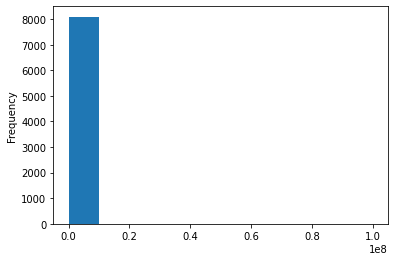

In [ ]:
plt.hist(df.minimum_nights )
plt.ylabel('Frequency')
plt.show()

In [ ]:
df = df.loc[df['minimum_nights'] <= 90]

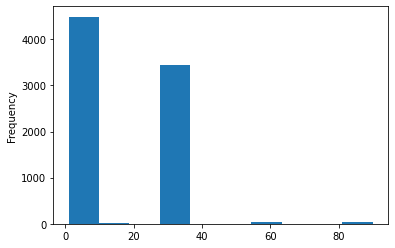

In [ ]:
plt.hist(df['minimum_nights'])
plt.ylabel('Frequency')
plt.show()

# Summary of data

In [ ]:
df.describe()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
count,8.048000e+03,8048.000000,8048.000000,8048.000000,8048.000000,8048.000000,8048.000000,8048.000000,8048.000000
mean,2.029726e+07,37.765978,-122.430199,2.184021,0.492545,1.394322,1.344930,14.971670,223.718315
std,1.226337e+07,0.022945,0.026987,3.650244,0.679691,0.923969,0.926024,15.020791,395.674248
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000
25%,8.993306e+06,37.751397,-122.442935,0.000000,0.000000,1.000000,1.000000,2.000000,100.000000
50%,2.163381e+07,37.769060,-122.424735,1.000000,0.000000,1.000000,1.000000,4.000000,150.000000
75%,3.121812e+07,37.785592,-122.410640,2.000000,1.000000,1.500000,2.000000,30.000000,240.000000
max,3.935418e+07,37.828790,-122.368570,25.000000,3.000000,14.000000,14.000000,90.000000,10000.000000


In summary
 - We can see that all listings are between 37.704630 and 37.828790 latitude and -122.513060 and -122.368570 longitude fitting to San Francisco geografical location
 - The price range between 10 and 10,000 USD with a standard deviation around 400 wich suggest a broad price distribution
 - The bathrooms vary between 0 and 14
 - The bedrooms vary between 0 and 14 also
 - The minimun nights go between 1 and 90 after we changed that

# Visualization and Correlation

Now we are going to visualize our data in differents graphs

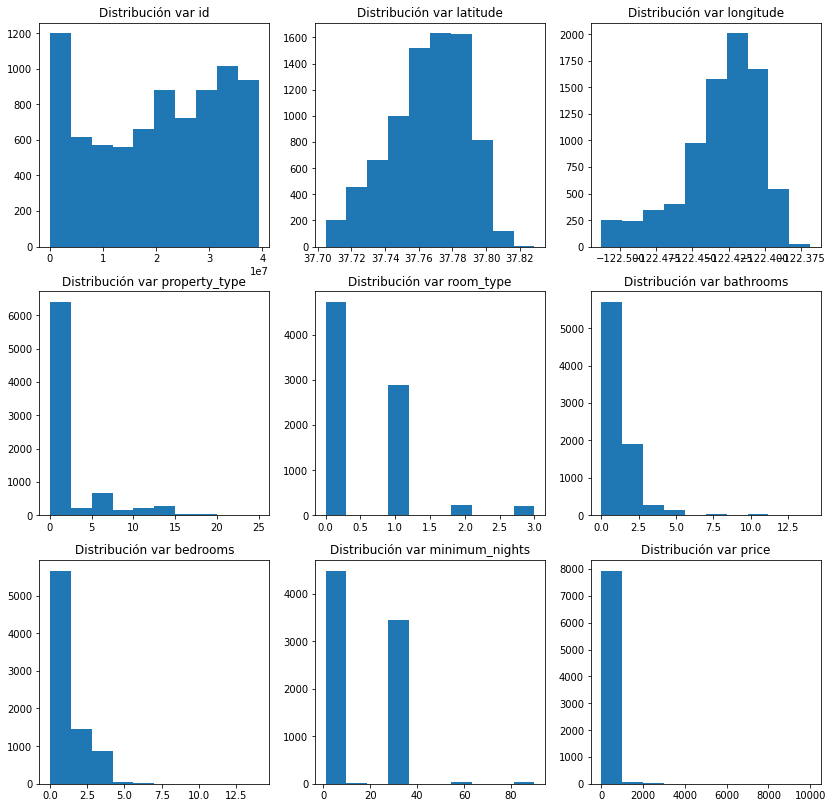

In [ ]:
plt.figure(figsize=(14,14))
n = 0
for i, column in enumerate(df.columns):
    n+=1
    plt.subplot(3, 3, n)
    plt.hist(df[column])
    plt.title('Distribución var {}'.format(column))
plt.show()

We can see thar there are some variables that are skewed:

 - bathrooms
 - bedrooms
 - minimum_nights
 - price
 
To reduce this we are goint to apply the log transform

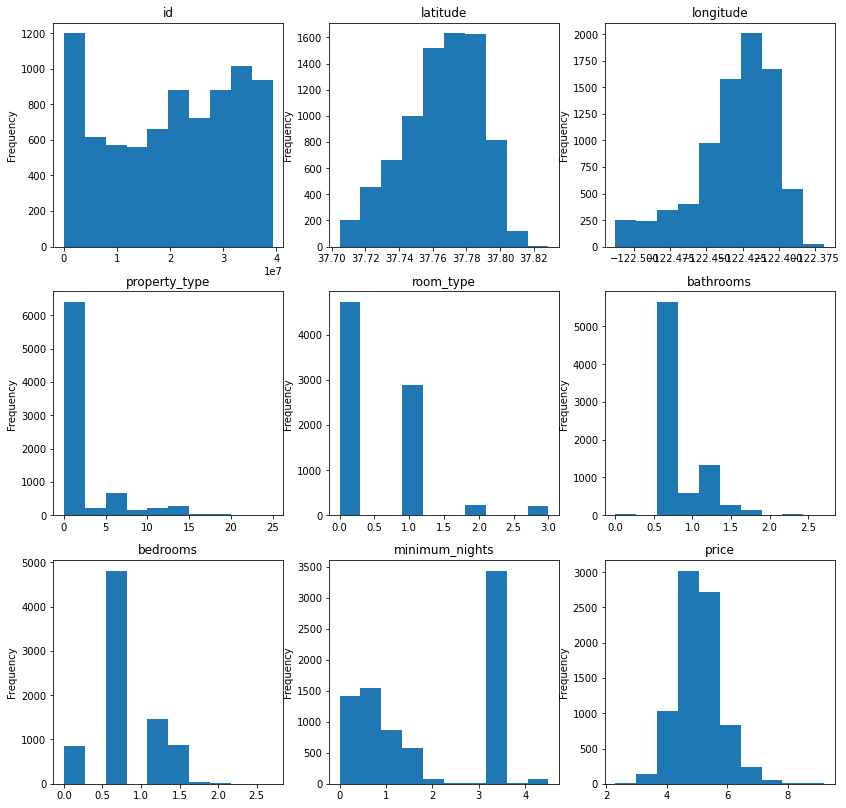

In [ ]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

ax1.hist(df.id)
ax1.set_ylabel("Frequency")
ax1.set_title(df.columns[0])

ax2.hist(df.latitude)
ax2.set_ylabel("Frequency")
ax2.set_title(df.columns[1])

ax3.hist(df.longitude)
ax3.set_ylabel("Frequency")
ax3.set_title(df.columns[2])

ax4.hist(df.property_type)
ax4.set_ylabel("Frequency")
ax4.set_title(df.columns[3])

ax5.hist(df.room_type)
ax5.set_ylabel("Frequency")
ax5.set_title(df.columns[4])

ax6.hist(np.log(df.bathrooms+1))
ax6.set_ylabel("Frequency")
ax6.set_title(df.columns[5])

ax7.hist(np.log(df.bedrooms+1))
ax7.set_ylabel("Frequency")
ax7.set_title(df.columns[6])

ax8.hist(np.log(df.minimum_nights))
ax8.set_ylabel("Frequency")
ax8.set_title(df.columns[7])

ax9.hist(np.log(df.price))
ax9.set_ylabel("Frequency")
ax9.set_title(df.columns[8])


plt.show()

We can now se them much clearly

We now transform the variables

In [ ]:
df['log_bedrooms'] = np.log(df.bedrooms +1)
df['log_bathrooms'] = np.log(df.bathrooms +1)
df["log_minimum_nights"] = np.log(df.minimum_nights)
df["log_price"] = np.log(df.price)

In [ ]:
df = df.drop(['bathrooms'], axis=1)
df = df.drop(['bedrooms'],axis=1)
df = df.drop(['minimum_nights'],axis=1)
df = df.drop(['price'],axis=1)

As the id doesn't help us in our problem we will also drop it

In [ ]:
df = df.drop(['id'],axis=1)

Now we separate our data in the dependent and independent variables

In [ ]:
X = df.drop('log_price',axis=1)
y = df['log_price']

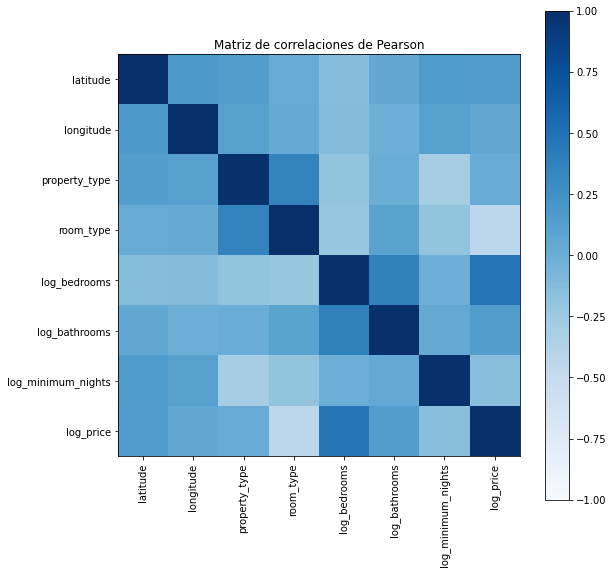

In [ ]:
matriz_correlaciones = df.corr(method='pearson')
n_ticks = len(df.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), df.columns, rotation='vertical')
plt.yticks(range(n_ticks), df.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')


In [ ]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlation with target'])

,Correlation with target
log_bedrooms,0.470452
room_type,-0.443313
latitude,0.158849
log_minimum_nights,-0.146345
log_bathrooms,0.141224
longitude,0.052486
property_type,0.011937


 - bedrooms seems correlated with the price in a positive way
 - room_type also seems correlated but in a negative way
 - latitude also is slightly correlated
 - minimum_nighs is also slightly corralated but in a negative way

# Train_Test_Split

Now we are going to split our data into test and train so we can later evaluate our model predictions

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Models

As this is a Regression Model type of problem our metric to evaluate the model is going to be the rmse(Root mean squared error)

## Ridge

The first model we are going to try is a basic ridge model

In [ ]:
modelo = Ridge()
parametros = {"alpha": list(range(1,20, 1))}

We will use a GridSerachCV to find the best parameters

In [ ]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='neg_mean_squared_error')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19]},
             scoring='neg_mean_squared_error')

In [ ]:
print(modelo_gs.best_params_)

{'alpha': 1}


Now that we have the parameters we set a model with those

In [ ]:
reg_lineal =  Ridge(alpha=modelo_gs.best_params_['alpha'])

In [ ]:
reg_lineal.fit(X_train, Y_train)

Ridge(alpha=1)

Now we will show some graphic that show the comparison between our predictions and the real values

The first one shows the real values and train data

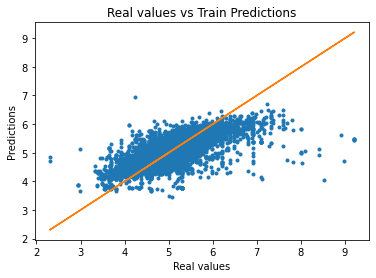

In [ ]:
Y_train_pred_ridge = reg_lineal.predict(X_train)
plt.title('Real values vs Train Predictions')
plt.xlabel('Real values')
plt.ylabel('Predictions')
_ = plt.plot(Y_train, Y_train_pred_ridge, '.', Y_train, Y_train, '-')

This secod graph shows the real values and our predictions

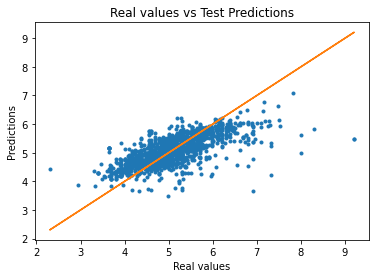

In [ ]:
Y_test_pred_ridge = reg_lineal.predict(X_test)
plt.title('Real values vs Test Predictions')
plt.xlabel('Real values')
plt.ylabel('Predictions')
_ = plt.plot(Y_test, Y_test_pred_ridge, '.', Y_test, Y_test, '-')

As they ask us to see that our predictions doesn't surpass the 25USD of the real values we will see the ones that enters our range

We have to remember that we used the log function so to undo this we use the exp that is the inverse of the log

In [ ]:
difference = np.exp(Y_test_pred_ridge) - np.exp(Y_test)

In [ ]:
interested = (difference <= 25 )

In [ ]:
df_interested = pd.DataFrame(interested)


In [ ]:
df_interested.log_price.value_counts()


True     1046
False     564
Name: log_price, dtype: int64

In [ ]:
df_interested.log_price.value_counts(normalize=True)


True     0.649689
False    0.350311
Name: log_price, dtype: float64

We can see that for our Ridge Regression we have a 65% of correct guests

In [ ]:
mse_rl = MSE ( Y_test,Y_test_pred_ridge)
rmse_rl = mse_rl**(1/2)
print(rmse_rl)

0.5326300587304771


We see that our evaluator metric the rmse is 0.53 which can be improved

## Decision Tree Regressor

Our next model is a Decision Tree Regressor, the first step is to define it

In [ ]:
dt = DecisionTreeRegressor()
parametros = {"max_depth":range(10,15),"criterion" : ["mse","mae"],'min_samples_leaf':[20,40]}

Again here we will use the GridSearchCV to find the best parameters to our model

In [ ]:
modelo_gs_dt = GridSearchCV(dt, param_grid=parametros,
                         cv = 5)
modelo_gs_dt.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': range(10, 15),
                         'min_samples_leaf': [20, 40]})

In [ ]:
print(modelo_gs_dt.best_params_)

{'criterion': 'mse', 'max_depth': 11, 'min_samples_leaf': 20}


In [ ]:
dt = DecisionTreeRegressor(max_depth = modelo_gs_dt.best_params_['max_depth'], min_samples_leaf = modelo_gs_dt.best_params_['min_samples_leaf'], random_state = 0,criterion = modelo_gs_dt.best_params_['criterion'] )

In [ ]:
dt.fit(X_train,Y_train)


DecisionTreeRegressor(max_depth=11, min_samples_leaf=20, random_state=0)

In [ ]:
y_pred_dt = dt.predict(X_test)


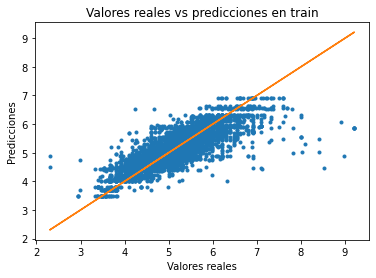

In [ ]:
Y_train_pred_dt = dt.predict(X_train)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_train, Y_train_pred_dt, '.', Y_train, Y_train, '-')

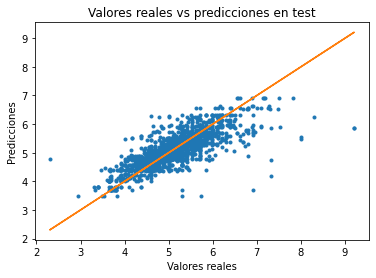

In [ ]:
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_test, y_pred_dt, '.', Y_test, Y_test, '-')

In [ ]:
difference = np.exp(y_pred_dt) - np.exp(Y_test)

In [ ]:
interested = (difference <= 25 )


In [ ]:
df_interested = pd.DataFrame(interested)


In [ ]:
df_interested.log_price.value_counts()


True     1119
False     491
Name: log_price, dtype: int64

In [ ]:
df_interested.log_price.value_counts(normalize=True)


True     0.695031
False    0.304969
Name: log_price, dtype: float64

We see here that we predict almost 70% of our data correct which is an improvement of the previous model

In [ ]:
mse_dt = MSE ( Y_test,y_pred_dt)
rmse_dt = mse_dt**(1/2)
print(rmse_dt)

0.46709190385776067


We also see that our model evaluator the rmse is lower than the one in the ridge regressor

## Random Forest Regressor

Our las model will be the Random Forest

In [ ]:
modelo_rf = RandomForestRegressor()
parametros = {"n_estimators": [50,100,200,400], "max_depth":range(10,20)}


As we did before we set a GridSearch to look for the best parameters

In [ ]:
modelo_gs_rf = GridSearchCV(modelo_rf, param_grid=parametros,
                         cv = 5)
modelo_gs_rf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(15, 20),
                         'n_estimators': [50, 100, 400]})

In [ ]:
print(modelo_gs_rf.best_params_)


{'max_depth': 15, 'n_estimators': 400}


Now that we have the parameters we create the model

In [ ]:
random_forest =  RandomForestRegressor(max_depth=modelo_gs_rf.best_params_['max_depth'],
                                      n_estimators=modelo_gs_rf.best_params_['n_estimators'])


In [ ]:
random_forest.fit(X_train, Y_train)


RandomForestRegressor(max_depth=15, n_estimators=400)

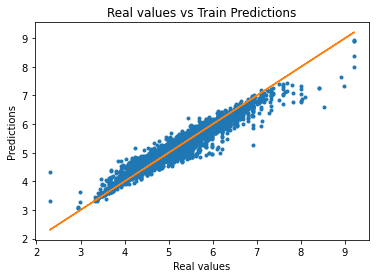

In [ ]:
Y_train_pred_rf = random_forest.predict(X_train)
plt.title('Real values vs Train Predictions')
plt.xlabel('Real values')
plt.ylabel('Predictions')
_ = plt.plot(Y_train, Y_train_pred_rf, '.', Y_train, Y_train, '-')

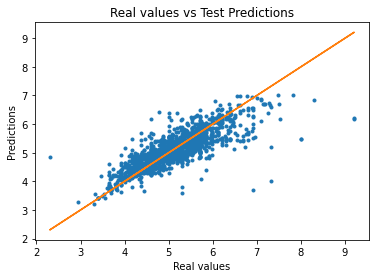

In [ ]:
Y_test_pred_rf = random_forest.predict(X_test)
plt.title('Real values vs Test Predictions')
plt.xlabel('Real values')
plt.ylabel('Predictions')
_ = plt.plot(Y_test, Y_test_pred_rf, '.', Y_test, Y_test, '-')

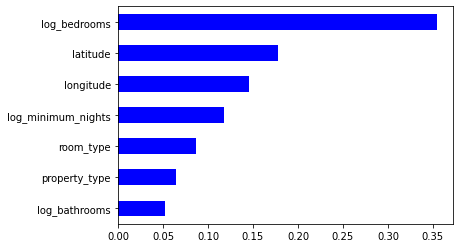

In [ ]:
importances_rf = pd.Series(random_forest.feature_importances_,index = X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh',color='blue')
plt.show()

From this graphic we can see that the most important features are the number of bedrooms followed by latitude and then minimum nights and longitude

In [ ]:
difference = np.exp(Y_test_pred_rf) - np.exp(Y_test)


In [ ]:
interested = (difference <= 25 )


In [ ]:
df_interested = pd.DataFrame(interested)


In [ ]:
df_interested.log_price.value_counts()


True     1157
False     453
Name: log_price, dtype: int64

In [ ]:
df_interested.log_price.value_counts(normalize=True)


True     0.718634
False    0.281366
Name: log_price, dtype: float64

This model predict a better percentage than the other it predict around a 72% of our prices between the ranges we require

In [ ]:
mse_rf = MSE ( Y_test,Y_test_pred_rf)
rmse_rf = mse_rf**(1/2)
print(rmse_rf)

0.42837316542589815


As expected the RamdomForestRegressor which is a more powerful model gives us the best rmse of the models we tried

# Conclusion

In [ ]:
# Print rmse_rl
print('Ridge Regressor test set RMSE: {:.2f}'.format(rmse_rl))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

# Print rmse_rf
print('Random Forest test set RMSE: {:.2f}'.format(rmse_rf))


Ridge Regressor test set RMSE: 0.53
Regression Tree test set RMSE: 0.47
Random Forest test set RMSE: 0.43


As mentioned before the best model for our problem is the RandomForestRegressor giving us the lowest rmse 

# Future Work

The best way to improve the model is to add more information, although the dataset is not exceotionally small it is no so big.

This type of case studies can be translated to platforms as airbnb where people can upload their homes to rent them

Another way to improve the work could be to add more variables, for example the reviews of the people it can be either a ranking by stars or points or a written review